In [35]:
import numpy as np 
import cv2 
from PIL import Image 
import matplotlib.pyplot as plt 

In [36]:
#dilating rgb is the first work
def dilate_rgb(newdepth, pix):
    for _ in range(pix):
        d1 = newdepth[3:, :, :] # down
        d2 = newdepth[:-3, :, :] # up
        d3 = newdepth[:, 3:, :] # right
        d4 = newdepth[:, :-3, :] # left
        newdepth[:-3, :,:] = np.where(newdepth[:-3,:,:] > 0, newdepth[:-3, :,:], d1)
        newdepth[3:, :,:] = np.where(newdepth[3:,:,:] > 0, newdepth[3:, :,:] , d2)
        newdepth[:,:-3,:] = np.where(newdepth[:,:-3,:] > 0, newdepth[:, :-3,:], d3)
        newdepth[:, 3:,:] = np.where(newdepth[:,3:,:] > 0, newdepth[:,3:,:], d4)

    return newdepth

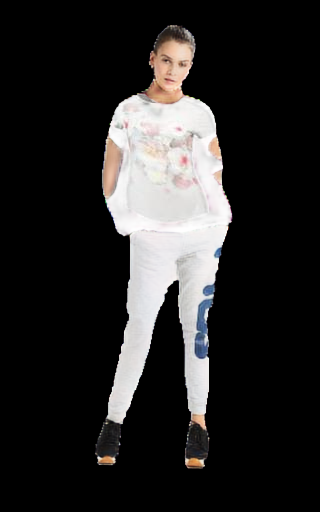

In [37]:
#rgb image is the 2D try-on output
rgb_image = Image.open("try-on/1FI21J006-C11@11=person_whole_front.png")
rgb_image

In [38]:
rgb_arr = np.array(rgb_image)
rgb_arr.shape

(512, 320, 3)

(256, 192, 3)


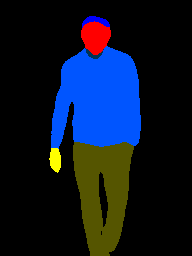

In [39]:
parsed_image = cv2.imread('ryan.png', 1)
print(parsed_image.shape )
Image.fromarray(parsed_image)

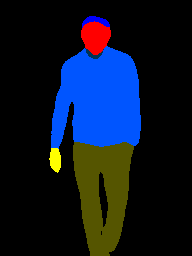

In [40]:
parse_shape = (np.sum(parsed_image, axis=2) > 0).astype(np.uint8)

inverted_mask = 255 - parse_shape


masked_image = cv2.bitwise_and(parsed_image, parsed_image, mask=inverted_mask)
Image.fromarray(masked_image)

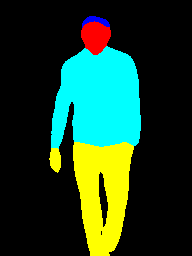

In [41]:
# binary_mask = [255 if p>0 else 0 for p in parsed_image]
binary_mask = parsed_image
for w in range(parsed_image.shape[0]):
    for h in range(parsed_image.shape[1]):
        for c in range(parsed_image.shape[2]):
            if(parsed_image[w][h][c]>0):
                binary_mask[w][h][c] = 255
            else:
                binary_mask[w][h][c] = 0
            
Image.fromarray(binary_mask)

In [42]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [43]:

cv2.erode?

Docstring:
erode(src, kernel[, dst[, anchor[, iterations[, borderType[, borderValue]]]]]) -> dst
.   @brief Erodes an image by using a specific structuring element.
.   
.   The function erodes the source image using the specified structuring element that determines the
.   shape of a pixel neighborhood over which the minimum is taken:
.   
.   \f[\texttt{dst} (x,y) =  \min _{(x',y'):  \, \texttt{element} (x',y') \ne0 } \texttt{src} (x+x',y+y')\f]
.   
.   The function supports the in-place mode. Erosion can be applied several ( iterations ) times. In
.   case of multi-channel images, each channel is processed independently.
.   
.   @param src input image; the number of channels can be arbitrary, but the depth should be one of
.   CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
.   @param dst output image of the same size and type as src.
.   @param kernel structuring element used for erosion; if `element=Mat()`, a `3 x 3` rectangular
.   structuring element is used. Kernel can be created us

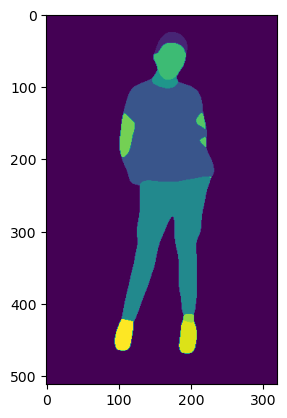

In [44]:
parsed_image = cv2.imread('segmt.png', 0)
plt.imshow(parsed_image)

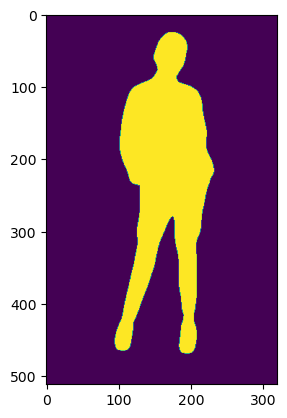

In [45]:
parse_shape_ = (parsed_image>0).astype(np.float64)
plt.imshow(parse_shape_)

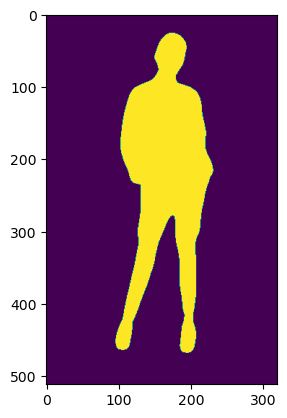

In [46]:
#parse shape erode for expanding the image re, lets see
parse_shape_erode = cv2.erode(parse_shape_, kernel)
plt.imshow(parse_shape_erode)

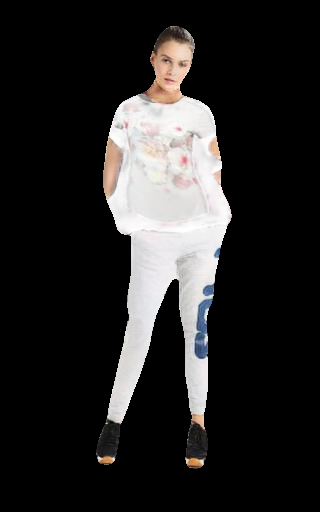

In [47]:
rgb_foreground = rgb_arr*np.expand_dims(parse_shape_erode, 2).astype(np.uint8)
Image.fromarray(rgb_foreground)

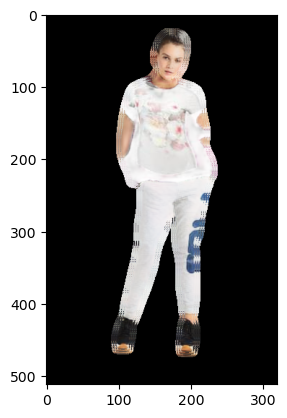

In [48]:
rgb_foreground_dilated = dilate_rgb(rgb_foreground, 2)
plt.imshow(rgb_foreground_dilated)

In [49]:
def inpaint_back(rgb, parse):
    inpaint_mask = (parse == 13).astype(np.uint8) * 255 + (parse == 10).astype(np.uint8) * 255
    plt.imshow(inpaint_mask)
    plt.show()
    person_inpainted = cv2.inpaint(rgb,inpaint_mask,3,cv2.INPAINT_TELEA)

    return person_inpainted

In [50]:
def plot_two(img1, img2):
    # Creating subplots
    plt.figure(figsize=(10, 15))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
    plt.imshow(img1, cmap='viridis')  # Display first image
    plt.title('Image 1')

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
    plt.imshow(img2, cmap='plasma')  # Display second image
    plt.title('Image 2')

    plt.tight_layout()
    plt.show()

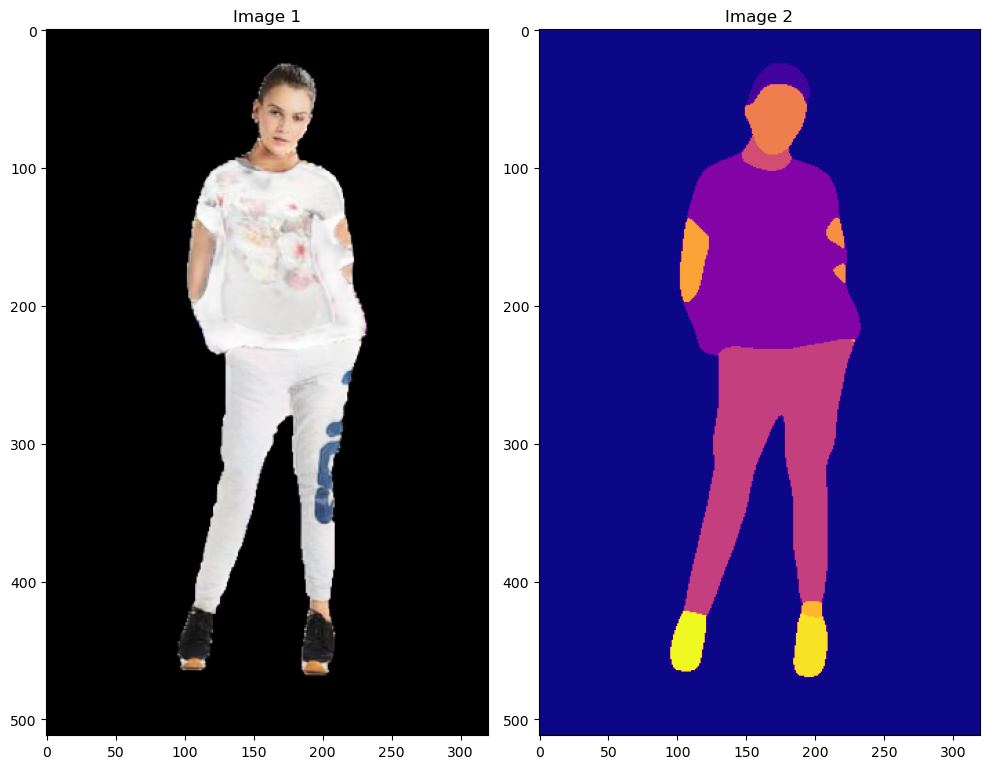

In [51]:
plot_two(rgb_arr, parsed_image)

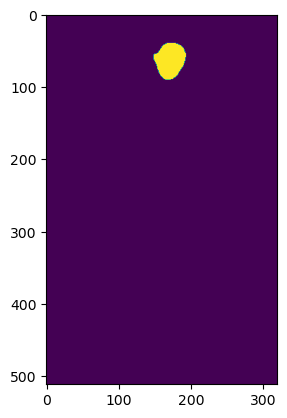

In [52]:
plt.imshow((parsed_image == 13).astype(np.uint8) * 255)

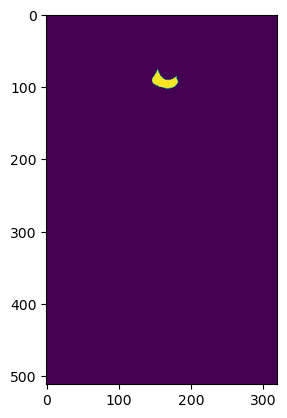

In [53]:
plt.imshow((parsed_image == 10).astype(np.uint8) * 255)

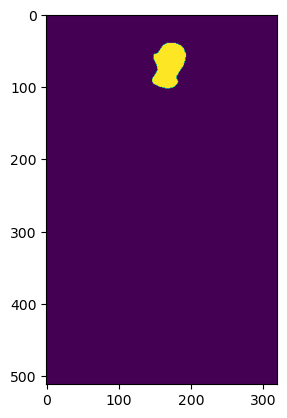

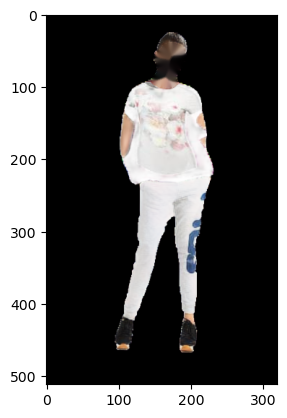

In [54]:
rgb_back = inpaint_back(rgb_arr, parsed_image)
plt.imshow(rgb_back)

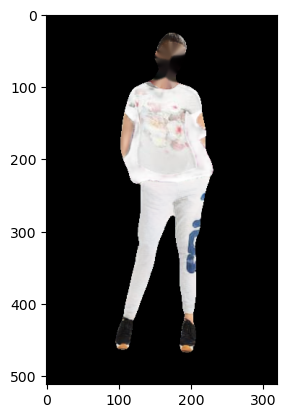

In [55]:
rgb_back *= np.expand_dims(parse_shape_erode,2).astype(np.uint8)
plt.imshow(rgb_back)

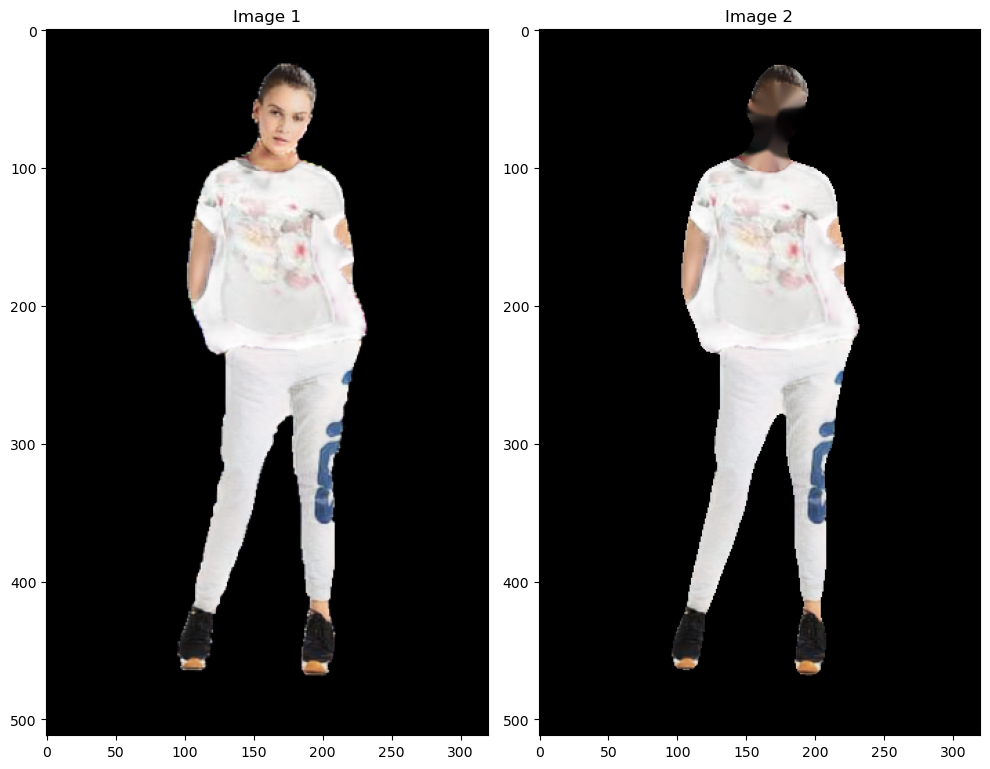

In [56]:
plot_two(rgb_arr, rgb_back)

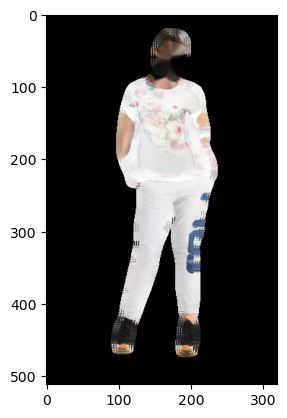

In [57]:
# rgb_back = rgb_dilate
rgb_back_dilate = dilate_rgb(rgb_back, 2)
plt.imshow(rgb_back_dilate)

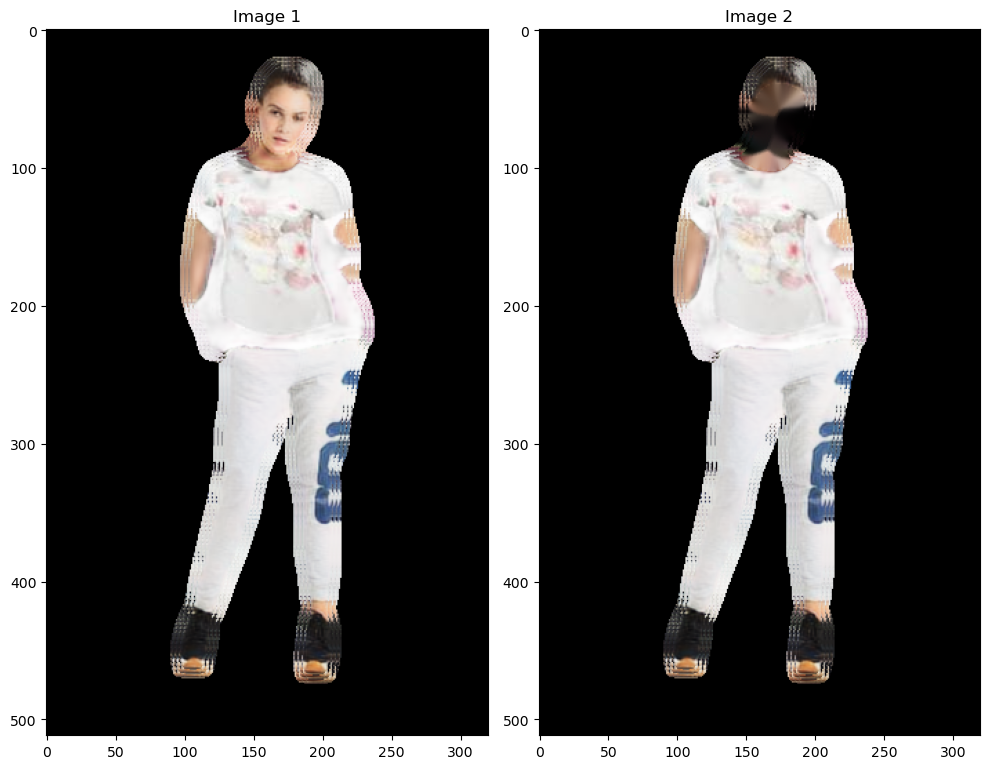

In [58]:
plot_two(rgb_foreground_dilated, rgb_back_dilate)

In [59]:
front_depth = np.load('whole_front_depth.npy')
back_depth = np.load('whole_back_depth.npy')
front_depth.shape, back_depth.shape

((512, 320), (512, 320))

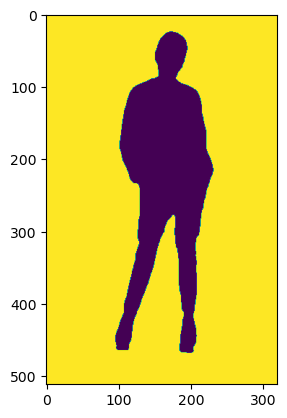

In [60]:
front_depth = front_depth - 0.02 
rm_idx = (front_depth-back_depth) < 0
plt.imshow(rm_idx)

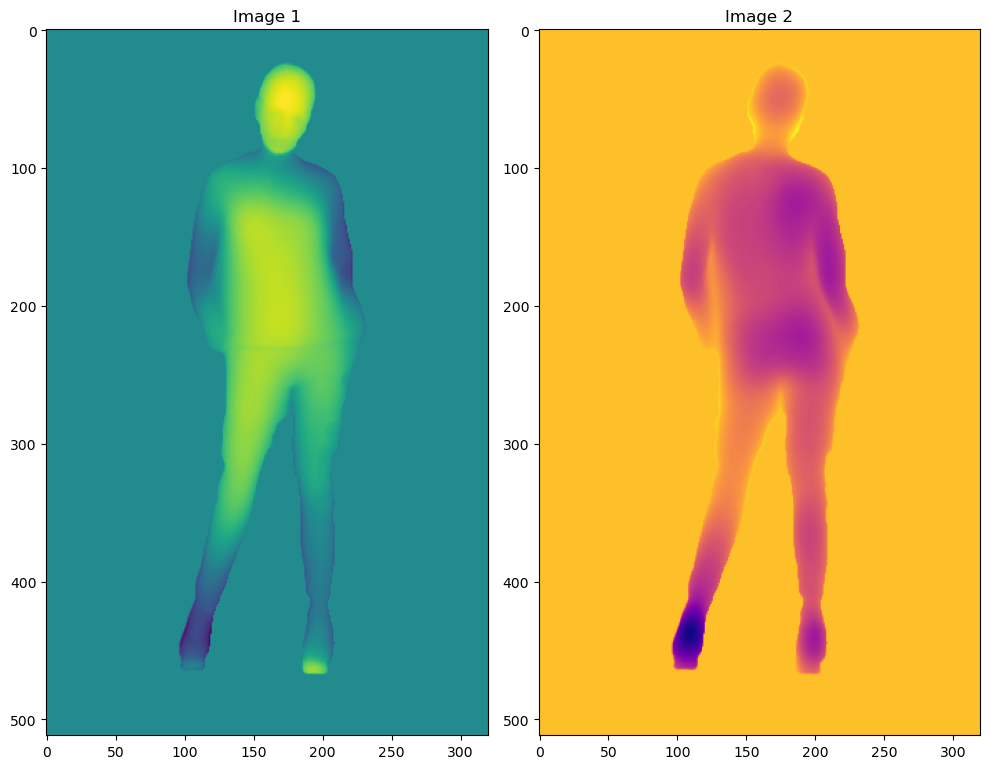

In [61]:
front_depth[rm_idx] = 0
back_depth[rm_idx] = 0
plot_two(front_depth, back_depth)

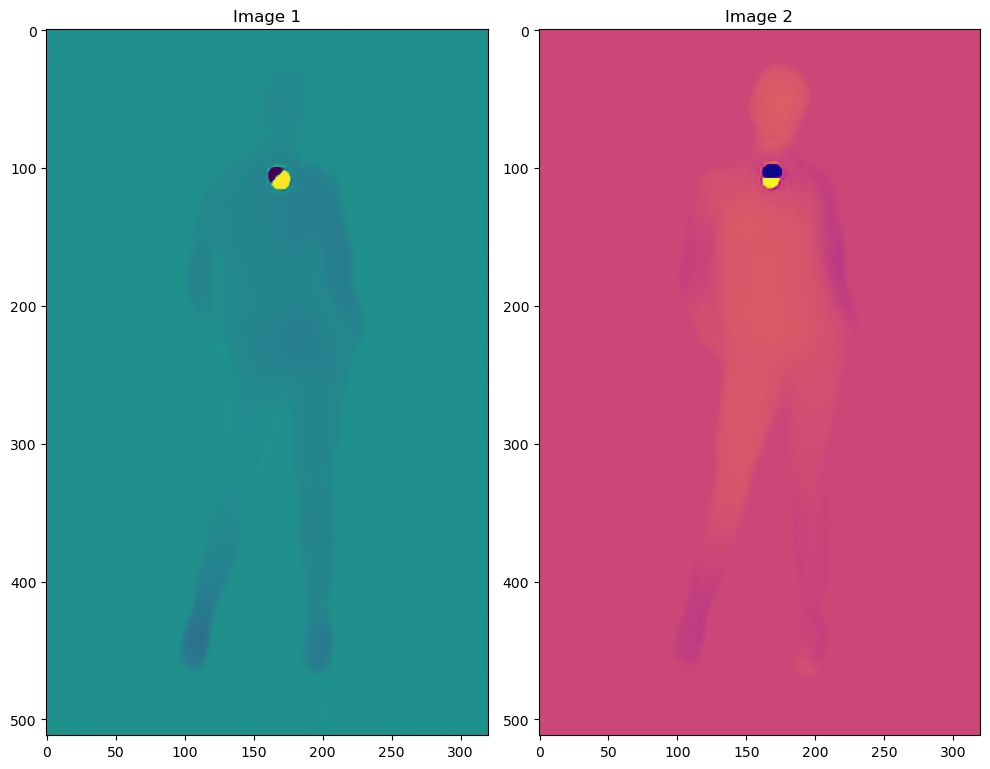

In [62]:
front_depth_initial = np.load('initial-depth/1FI21J006-C11@11=person_initial_back_depth.npy')
back_depth_initial=np.load('initial-depth/1FI21J006-C11@11=person_initial_front_depth.npy')
plot_two(front_depth_initial, back_depth_initial)


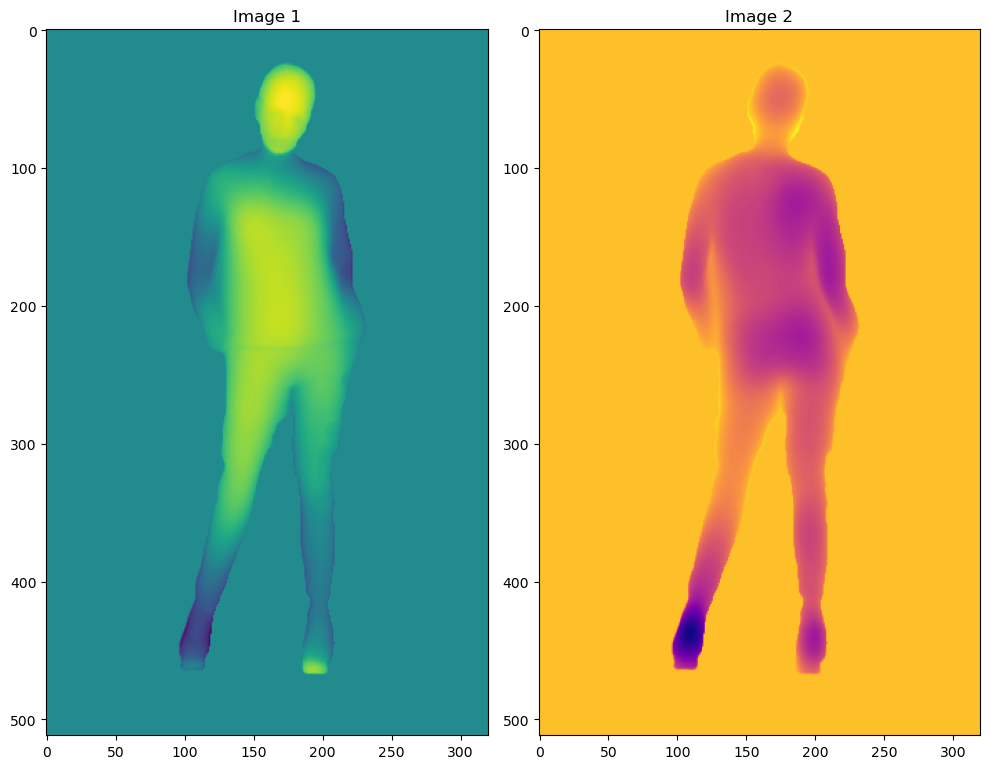

In [64]:
plot_two(front_depth, back_depth)

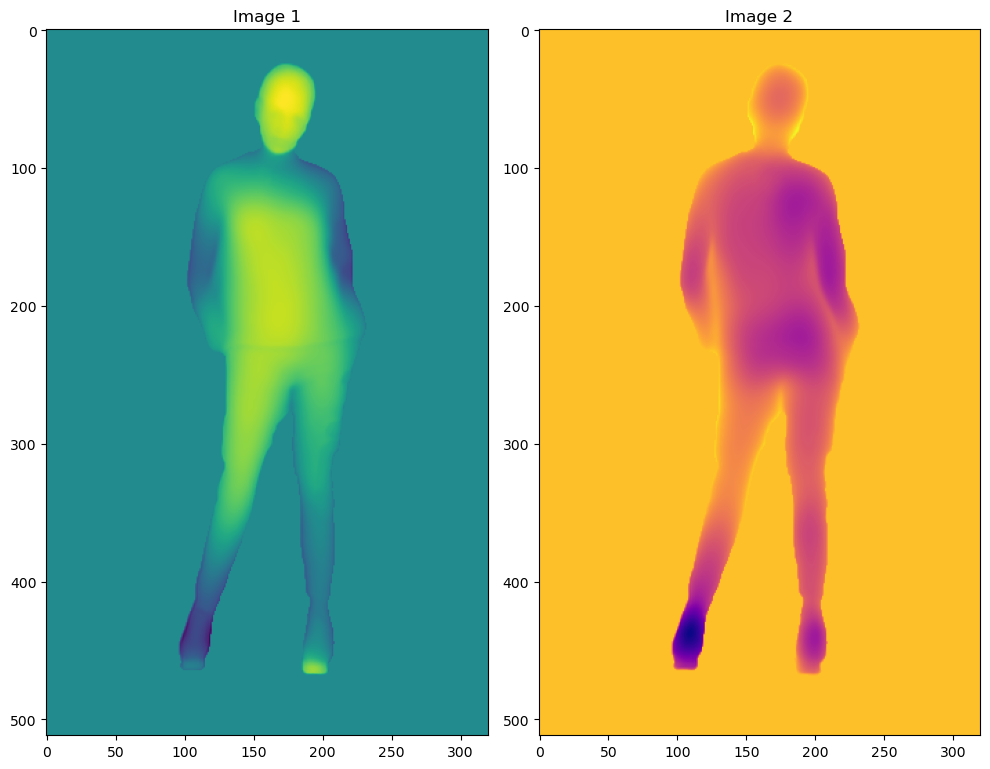

In [66]:
front_depth = front_depth * parse_shape_
back_depth = back_depth * parse_shape_
plot_two(front_depth, back_depth)

In [86]:
points = []
points2 = []

In [87]:
all_X = []
all_Y = []
all_Z = []

In [92]:
import open3d as o3d
import trimesh
import numpy as np

In [88]:
for h in range(front_depth.shape[0]):
    for w in range(front_depth.shape[1]):
        if(front_depth[h, w] ==0.):
            continue 
        color = rgb_foreground_dilated[h, w]
        Z = front_depth[h, w]
        X = (w+95)/256 - 1
        Y = (512-1-h)/256 - 1
        all_X.append(X)
        all_Y.append(Y)
        all_Z.append(Z)
        points.append("%f %f %f %d %d %d\n" % (X, Y, Z, color[0], color[1], color[2]))
        points2.append("%f %f %f %d %d %d\n" % (X, Y, Z, 255,255,255))

In [81]:
len(all_X), len(all_Y), len(all_Z)

(31262, 31262, 31262)

In [82]:
type(color), type(Z), type(X), type(Y)

(numpy.ndarray, numpy.float64, float, float)

In [83]:
len(points)

31262

In [89]:
file = open('base_dilated_white.ply', "w")
file.write('''ply
format ascii 1.0
element vertex %d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
%s
''' % (len(points2), "".join(points2)))
file.close()

In [38]:
back_depth.shape

(512, 320)

In [39]:
for h in range(back_depth.shape[0]):
    for w in range(back_depth.shape[1]):
        if(back_depth[h, w] ==0.):
            continue 
        color = rgb_back[h, w]
        Z = back_depth[h, w]
        X = (w+95)/256 - 1
        Y = (512-1-h)/256 - 1
        
        points.append("%f %f %f %d %d %d\n" % (X, Y, Z, color[0], color[1], color[2]))

In [40]:
color[0], color[1], color[2], X, Y, Z, h, w, Z

(181,
 145,
 103,
 0.15625,
 -0.83203125,
 -0.005035704933106899,
 511,
 319,
 -0.005035704933106899)

In [41]:
points[-1]

'0.156250 -0.832031 -0.005036 181 145 103\n'

In [42]:
back_depth[511,319]

0.0

In [43]:
len(points)

62524

In [44]:
points_ = []

In [63]:
empty = 0
for h in range(back_depth.shape[0]):
    for w in range(back_depth.shape[1]):
        if(back_depth[h, w] ==0.):
            # pass
            empty+=1
            continue 
        color = rgb_back[h, w]
        Z_ = back_depth[h, w]
        X_ = (w+95)/256 - 1
        Y_ = (512-1-h)/256 - 1
        print(color) 
        points_.append("%f %f %f %d %d %d\n" % (X_, Y_, Z_, color[0], color[1], color[2]))
print(empty)

[39 38 35]
[73 71 61]
[119 111  98]
[75 67 65]
[65 60 57]
[86 80 76]
[72 67 66]
[73 65 62]
[72 62 57]
[82 74 65]
[75 68 59]
[39 34 31]
[37 32 30]
[33 30 28]
[143 135 114]
[154 147 132]
[126 119 111]
[154 144 133]
[136 126 120]
[111 100  97]
[129 115 105]
[87 74 69]
[79 63 58]
[108  97  83]
[60 55 50]
[59 53 51]
[95 84 82]
[39 35 35]
[37 33 30]
[38 32 29]
[84 76 67]
[52 47 41]
[79 74 63]
[113 107  94]
[89 81 73]
[101  90  80]
[98 90 82]
[63 58 56]
[70 59 55]
[75 61 56]
[90 79 66]
[69 58 48]
[35 26 25]
[49 38 38]
[80 74 72]
[86 85 83]
[37 31 30]
[35 29 27]
[98 99 94]
[74 71 64]
[54 50 45]
[39 38 35]
[73 71 61]
[119 111  98]
[75 67 65]
[65 60 57]
[86 80 76]
[72 67 66]
[73 65 62]
[72 62 57]
[82 74 65]
[75 68 59]
[37 32 32]
[61 55 53]
[94 90 85]
[96 98 91]
[140 133 128]
[165 159 155]
[40 35 34]
[36 30 27]
[60 58 55]
[42 38 36]
[39 34 31]
[37 32 30]
[33 30 28]
[54 51 45]
[82 75 65]
[56 51 49]
[58 55 54]
[93 88 84]
[88 81 80]
[77 69 66]
[59 53 48]
[71 64 56]
[108  97  83]
[60 55 50]
[59 53 51

In [68]:
rgb_back.shape , 512*310*3, back_depth.shape  

((512, 320, 3), 476160, (512, 320))

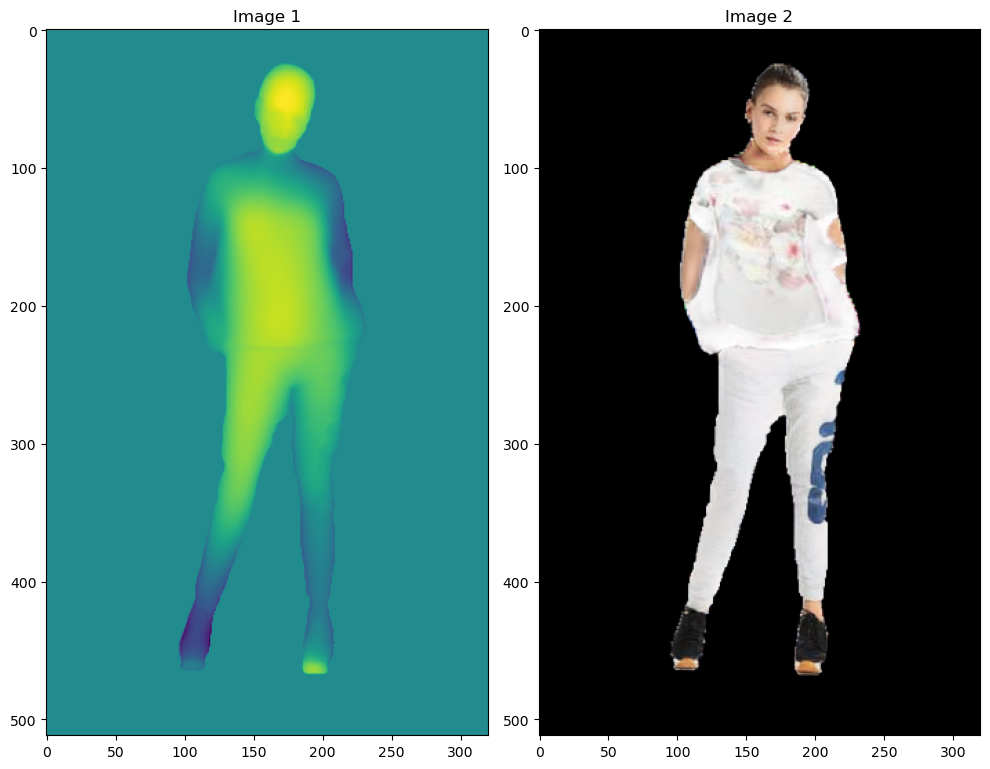

In [73]:
plot_two(front_depth, rgb_arr) 

In [59]:
for a in points_:
    X_, Y_, Z_, _, _, _ = a.split(' ')
    print(a)
    break
# [[X_, Y_, Z_] for X_, Y_, Z_, _, _, _ in points_]

0.031250 0.898438 0.002119 39 38 35



In [61]:
file = open('base_only_back_.ply', "w")
file.write('''ply
format ascii 1.0
element vertex %d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
%s
''' % (len(points_), "".join(points_)))
file.close()

In [79]:
file = open('base_back_.ply', "w")
file.write('''ply
format ascii 1.0
element vertex %d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
%s
''' % (len(points), "".join(points)))
file.close()

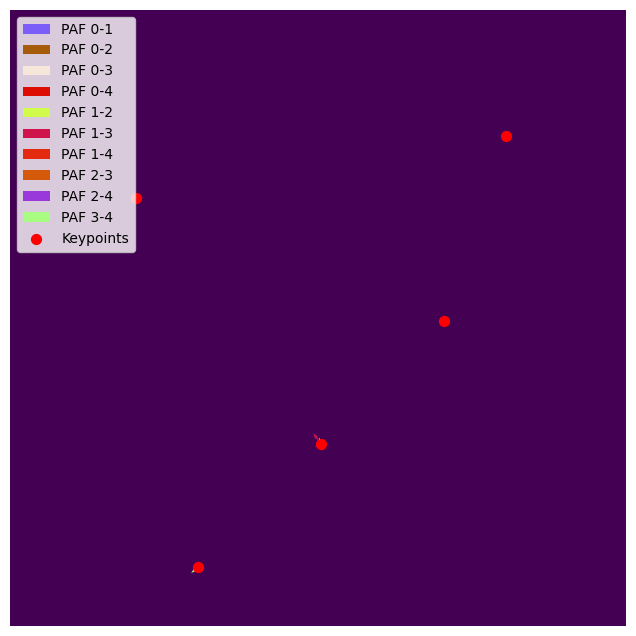

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate keypoints for better visualization (5 keypoints)
keypoints = np.array([
    [20, 30],  # Key point 1
    [50, 70],  # Key point 2
    [80, 20],  # Key point 3
    [30, 90],  # Key point 4
    [70, 50]   # Key point 5
])

# Simulate PAFs based on keypoints (simplified for demonstration)
num_keypoints = len(keypoints)
num_pafs = num_keypoints * (num_keypoints - 1) // 2  # Number of PAFs

# Generating random PAFs (simplified for demonstration)
pafs_x = np.random.randn(num_keypoints, num_keypoints)
pafs_y = np.random.randn(num_keypoints, num_keypoints)

# Visualize PAFs using quiver plot
plt.figure(figsize=(8, 8))
plt.imshow(np.ones((100, 100)))  # Display a blank image for context

for i in range(num_keypoints):
    for j in range(i + 1, num_keypoints):
        plt.quiver(
            keypoints[i, 0], keypoints[i, 1],
            pafs_x[i, j], pafs_y[i, j],
            angles='xy', scale_units='xy', scale=1,
            color=np.random.rand(3,), width=0.002,
            label=f"PAF {i}-{j}"
        )

plt.scatter(keypoints[:, 0], keypoints[:, 1], color='red', s=50, label='Keypoints')
plt.legend()
plt.axis('off')
plt.show()
